In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


from keras.models import Model
from keras.layers import Input, Dense, Layer
from keras.losses import Loss, mse
from keras.initializers import GlorotNormal
from keras.optimizers import Optimizer
import kormos

np.random.seed(1234)
tf.random.set_seed(1234)

In [8]:
def printest(args, valor):
    return print( "{} : \n {} \n".format(args, valor) )


# PINN : Navier Strokes

## Otimizador

In [30]:
# Problem with optimizer
class L_BFGS_B:
    def __init__(self, model, 
                 x_train, 
                 y_train, factr = 1, m=50, maxls=50, maxfun = 50000, maxiter=50000):
        
        self.model = model
        #x_train = xyt, y_train = uv
        self.x_train =  x_train
        self.y_train = y_train  
        self.factr = factr
        #The maximum number of variable metric corrections used 
        self.m = m
        #max number of line search steps/iteration
        self.maxls = maxls 
        self.maxiter = maxiter

        self.maxfun = maxfun       

    def unflatten_weights(self, flat_weights, shapes):

        """
        Set weights to the model.

        Args:
            flat_weights: flatten weights.
        """
        n = [0] + [ np.prod(shape) for shape in shapes] 
        partition = np.cumsum(n)
        
        #printest('n',n)
        #printest('partition',partition)
        #printest('partition[:-1]',partition[:-1])
        #printest('partition[1:]',partition[1:])
    
        weights = [ flat_weights[from_part:to_part].reshape(shape)
                    for from_part, to_part, shape 
                    in zip(partition[:-1], partition[1:], shapes) ]
                    
        return weights

    @tf.function
    def tf_evaluate(self, x, y, trainable_variables):
        """
        Evaluate loss and gradients for weights as tf.Tensor.
        Args:
            x: input data.
        Returns:
            loss and gradients for weights as tf.Tensor.
        """
        # wehre x = xyt , y = uv
        with tf.GradientTape() as g:
            uv_fuv = self.model([x, y])       
            loss = self.model.losses[0]
        grads = g.gradient(loss, trainable_variables, unconnected_gradients = tf.UnconnectedGradients.ZERO)

        #printest('loss',loss)
        
        return loss, grads

    def evaluate(self, flat_weights, *args):
        var_shapes, fix_weights = args

        var_weights = self.unflatten_weights(flat_weights, var_shapes)

        
        # Combine the two list of variables (like extend)
        weights = var_weights + fix_weights

        # put the weights in the model
        self.model.set_weights(weights) 

        #train only the required weights of the model (the first two weights)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train, self.model.trainable_variables[0:2])
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')
        printest('loss', loss)
        
        return loss, grads
    
    def fit(self, var_weights, fix_weights):

        """
        Train the model using L-BFGS-B algorithm.
        """
        var_shapes = [ w.shape for w in var_weights]
        initial_weights = np.concatenate([ w.flatten() for w in var_weights ])

        return fmin_l_bfgs_b(func = self.evaluate, x0 = initial_weights, args = (var_shapes, fix_weights) ,
                        factr = self.factr, m = self.m,   
                        maxls = self.maxls, maxiter = self.maxiter, 
                        maxfun = self.maxfun)

## Layer: automatic Differentiation and Loss

In [3]:
class AutomaticDiff(Layer):

    def __init__(self, model):
        
        self.model = model
        super().__init__()
        self.lambda_1 = tf.Variable([0.0], trainable=True, dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], trainable=True, dtype=tf.float32)
    
    def call(self, input): 
        with tf.GradientTape(persistent = True) as ggg:
            ggg.watch(input)
            with tf.GradientTape(persistent = True) as gg:
                gg.watch(input)
                with tf.GradientTape(persistent = True) as g:
                    g.watch(input)

                    x = input[:,0:1]        # (5000, 1)
                    y = input[:,1:2]        # (5000, 1)
                    t = input[:,2:3]        # (5000, 1)
                    xy = tf.concat([x, y], axis = 1)        # (5000, 2)
                    xyt = tf.concat([xy, t], axis = 1)      # (5000, 3)
                    
                    p_psi = self.model(xyt) # (5000, 2)              
                    p   = p_psi[:,0:1]      # (5000, 1)
                    psi = p_psi[:,1:2]      # (5000, 1)    

                dpdpsi_dxdy = g.batch_jacobian(p_psi, xy)  ## (5000, 2, 2)
                dp_dxdy   = dpdpsi_dxdy[:,0,:] # (5000, 2 )
                dp_dx = dp_dxdy[:,0:1]      # (5000, 1 )
                dp_dy = dp_dxdy[:,1:2]      # (5000, 1 )
                # --> dpsi_dx = -v and dpsi_dy = u
                dpsi_dxdy = dpdpsi_dxdy[:,1,:] # (5000, 2 )
                v = (-1)*dpsi_dxdy[:, 0:1]  # (5000, 1 )
                u = dpsi_dxdy[:, 1:2]       # (5000, 1 )         
            
            dpsi_dxdy_dxdydt = gg.batch_jacobian(dpsi_dxdy, xyt) # (5000, 2, 3)
            # from continuity eq u_x + u_y = 0 
            # --> dpsi_dx = -v and dpsi_dy = u
            # --> (dpsi_dy)dx_dxdydt = du_dxdydt
            du_dxdydt = dpsi_dxdy_dxdydt[:,1,:]            ## (5000, 3)
            du_dx = du_dxdydt[:,0:1]       # (5000, 1)
            du_dy = du_dxdydt[:,1:2]       # (5000, 1)
            du_dt = du_dxdydt[:,2:3]       # (5000, 1)
            # --> (dpsi_dx)dy_dxdydt = (-1)*dv_dxdydt
            dv_dxdydt = (-1)*dpsi_dxdy_dxdydt[:,0,:]       ## (5000, 3)
            dv_dx = dv_dxdydt[:,0:1]       # (5000, 1)
            dv_dy = dv_dxdydt[:,1:2]       # (5000, 1)
            dv_dt = dv_dxdydt[:,2:3]       # (5000, 1)
        #-------------------------------------------------------------------
        d2u_dx2 = ggg.gradient(du_dx, x)   #(5000, 1)
        d2u_dy2 = ggg.gradient(du_dx, y)   #(5000, 1)
        d2v_dx2 = ggg.gradient(dv_dx, x)   #(5000, 1)
        d2v_dy2 = ggg.gradient(dv_dx, y)   #(5000, 1)
        #-------------------------------------------------------------------
        del g, gg, ggg

        f_u = du_dt + self.lambda_1*(u*du_dx + v*du_dy) + dp_dx - self.lambda_2*(d2u_dx2 + d2u_dy2) 
        
        f_v = dv_dt + self.lambda_1*(u*dv_dx + v*dv_dy) + dp_dy - self.lambda_2*(dv_dx + d2v_dy2)

        output = tf.concat([u, v, f_u, f_v], axis = 1)
        return output


In [4]:
class AddLoss(Layer):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):
        self.add_loss(self.custom_mse(y_true, y_pred))
        return y_pred
    
    def custom_mse(self, y_true, y_pred ):
        
        u_true, u_pred = y_true[:,0:1], y_pred[:,0:1]
        loss_1 =  tf.reduce_sum(tf.square(u_true - u_pred))
        
        v_true, v_pred = y_true[:,1:2], y_pred[:,1:2]
        loss_2 =  tf.reduce_sum(tf.square(y_true[:,1:2] - y_pred[:,1:2]))
        
        f_u_pred, f_v_pred = y_pred[:,2:3], y_pred[:,3:4]
        loss_3 =  tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred))
        
        loss = loss_1 + loss_2 + loss_3
        return loss

## Model: Neural Network

In [9]:
class NeuralNet(Model):
    def __init__(self, hidden_units = [20, 20, 20, 20, 20, 20, 20, 20], input_unit = 3, output_unit = 2, activation_func = 'tanh', initializer = "glorot_normal"):
        super().__init__()

        self.units = hidden_units
        self.input_unit = input_unit
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.initializer = initializer
        # Hidden Layer
        self.hidden_layer = []
        count = 0
        for unit in hidden_units:
            self.hidden_layer.append( Dense( units = unit, 
                                             kernel_initializer = self.initializer, 
                                             activation = activation_func,
                                             name = 'Hidden_{}'.format(count) ) )
            count += 1
            
        # Output layer    
        self.output_layer = Dense( units = output_unit, 
                                    kernel_initializer = self.initializer,
                                    name = "Output" )

    def call(self, x): # call directly if dont need intermediate step
        for hidden in self.hidden_layer:
            x = hidden(x)
        x = self.output_layer(x)
        return x


    def build(self): # intermediate step
        x = Input( shape = (self.input_unit,), name = "Input" )
        return Model( inputs = [x], 
                        outputs = self.call(x), 
                        name = "NeuralNetwork" )

### Model: graph visualization

In [7]:
nn_model = NeuralNet().build()

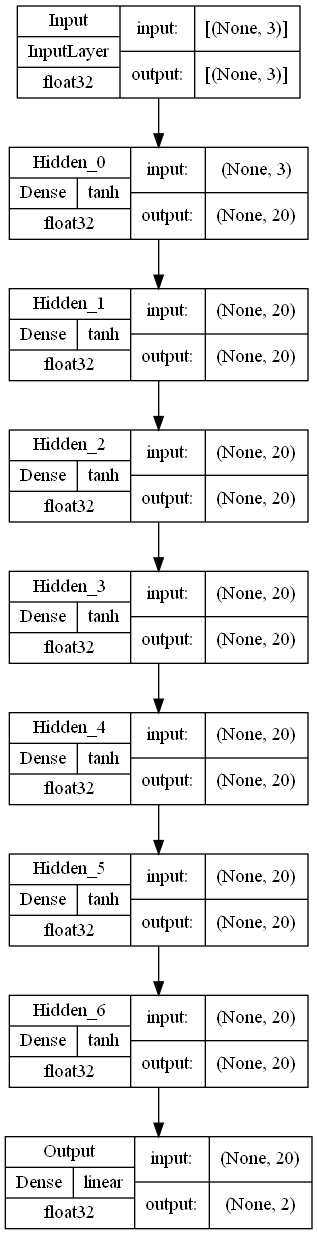

In [8]:

tf.keras.utils.plot_model(nn_model, to_file= './model_1.png', show_shapes=True, 
                    show_dtype=True, show_layer_names=True, show_layer_activations = True)

## Model: Physics Informed

In [10]:
class PhysicsInformedNN(Model):
    def __init__(self, model):
        super(PhysicsInformedNN, self).__init__()
        
        # init layers 
        self.model = model
        self.grad_layer = AutomaticDiff(model)
        self.addloss_layer = AddLoss( )
    
    def call(self, inputs):
        xyt = inputs[0]
        uv = inputs[1]
        # uv_fuv =  u, v, f_u, f_v
        uv_fuv =  self.grad_layer(xyt) 
        uv_fuv = self.addloss_layer(y_true = uv, y_pred = uv_fuv)
        return uv_fuv
    
    def build(self):  
        xyt = Input(shape = (3,), name = "InputLayer_xyt")
        uv = Input(shape = (2,), name = "InputLayer_uv")
        inputs = [xyt, uv]
        return Model(inputs = inputs,
                     outputs = self.call(inputs),
                     name = 'PhysicsInformedNN')

### Model: graph visualization

In [10]:
pinn_model = PhysicsInformedNN(model = nn_model).build()

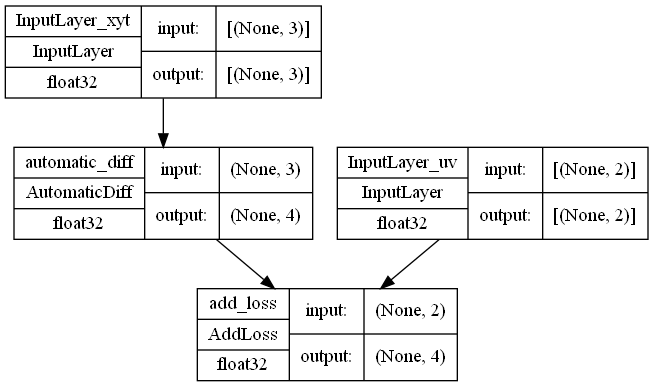

In [11]:
tf.keras.utils.plot_model(pinn_model, to_file= './pinn_1.png', show_shapes= True,
                    show_dtype=True, show_layer_names=True, show_layer_activations = True)

## Main

In [19]:
n_train = 5000
n_test = 5000

# load dictionary Data
# keys: 'X_star: [x, y]', 'U_star : [u, v]', 'p_star : [p]', 't : [t]',
data = loadmat('./Data/cylinder_nektar_wake.mat')

# Rearrange Data                        shapes:
uv = data['U_star']                 # (5000, 2, 200) - N x 2 X T
u = uv[:,0,:]                       # (5000, 200)     - N x T
v = uv[:,1,:]                       # (5000, 200)     - N x T

# N = 5000, T = 200
N,T = (uv.shape[0], uv.shape[2]) 

xy = data['X_star']                 # (5000, 2)      - N x 2
x = np.tile(xy[:, 0:1], (1,T))      # (5000, 200)    - N x T
y = np.tile(xy[:, 1:2], (1,T))      # (5000, 200)    - N x T

t = data['t']                       # (200 , 1)      - T x 1
tt = np.tile(t, (1,N)).T             # (5000, 200)     - N x T
p = data['p_star']                  # (5000, 200)     - N x T

# 1D arrays : (10000, 1) - NT x 1
x_1d = x.flatten()[:,None]
y_1d = y.flatten()[:,None]
t_1d = tt.flatten()[:,None]

u_1d = u.flatten()[:,None]          
v_1d = v.flatten()[:,None]          
p_1d = p.flatten()[:,None]

# Training Data : (5000, 1)
indices = np.random.choice(N*T, n_train, replace = False)
xyt_train = tf.concat( (x_1d[indices], y_1d[indices], t_1d[indices]), axis = 1)
uv_train  = tf.concat( (u_1d[indices], v_1d[indices]), axis = 1) 

# Traning
nn_model = NeuralNet().build()
pinn_model = PhysicsInformedNN(model = nn_model).build()

# Adam Optimizer all weights
pinn_model.compile(loss = AddLoss(), optimizer = tf.optimizers.Adam(learning_rate=0.001))
pinn_model.fit(x = [xyt_train, uv_train], y = uv_train, epochs=2000, batch_size=32)


Epoch 1/2000
157/157 [==============================] - 18s 4ms/step - loss: 9.5076
Epoch 2/2000
157/157 [==============================] - 1s 4ms/step - loss: 4.1166
Epoch 3/2000
157/157 [==============================] - 1s 4ms/step - loss: 3.8203
Epoch 4/2000
157/157 [==============================] - 1s 4ms/step - loss: 3.6002
Epoch 5/2000
157/157 [==============================] - 1s 4ms/step - loss: 3.4541
Epoch 6/2000
157/157 [==============================] - 1s 4ms/step - loss: 3.3504
Epoch 7/2000
157/157 [==============================] - 1s 4ms/step - loss: 3.2355
Epoch 8/2000
157/157 [==============================] - 1s 4ms/step - loss: 3.0678
Epoch 9/2000
157/157 [==============================] - 1s 4ms/step - loss: 2.9509
Epoch 10/2000
157/157 [==============================] - 1s 4ms/step - loss: 2.8270
Epoch 11/2000
157/157 [==============================] - 1s 4ms/step - loss: 2.6558
Epoch 12/2000
157/157 [==============================] - 1s 4ms/step - loss: 2.4948


In [29]:
# Problem: problem with L_BFGS_B optimizer
# L_BFGS_B Optimizer for lambdas
var_weights = pinn_model.get_weights()[0:2]
fix_weights = pinn_model.get_weights()[2:]

lbfgs = L_BFGS_B(model = pinn_model, x_train = xyt_train, y_train = uv_train)
lbfgs.fit(var_weights = var_weights, fix_weights = fix_weights)

loss : 
 6.101031303405762 

loss : 
 2965.1162109375 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 

loss : 
 6.101031303405762 



(array([1.00215113, 0.00764226]),
 6.101031303405762,
 {'grad': array([-0.00050449,  0.00041962]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 13,
  'nit': 1,
  'warnflag': 0})

## Plot

In [21]:
# Data test
snapshot = [100]         # state of a system at a particular point in time
x_test = xy[:,0:1]
y_test = xy[:,1:2]
t_test = tt[:,snapshot]

xyt_test = tf.concat( (x_test, y_test, t_test), axis = 1)

u_test = uv[:,0,snapshot]
v_test = uv[:,1,snapshot]

uv_test = tf.concat( (u_test, v_test), axis = 1)
p_test = p[:,snapshot]

# predict
p_psi = nn_model.predict(xyt_test, batch_size = len(xyt_test))


1/1 [==============================] - 0s 102ms/step


In [22]:
min_val = xy.min(0)
max_val = xy.max(0)
n_points = 200

x = np.linspace(min_val[0], max_val[0], n_points)
y = np.linspace(min_val[1], max_val[1], n_points)
X, Y = np.meshgrid(x,y)

P_pred = griddata(xy, p_psi[:,1].flatten(), (X,Y) , method = "cubic")
Psi_pred = griddata(xy, p_psi[:,0].flatten(), (X,Y) , method = "cubic")
P_exact = griddata(xy, p_test.flatten(), (X, Y), method='cubic')



In [23]:
fig =  plt.figure(figsize=(10, 10))
gs = GridSpec(nrows = 1, ncols = 2)

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Exact pressure')

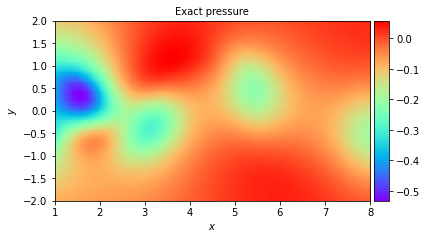

In [24]:
ax = plt.subplot(111)
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()], 
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 10)

Text(0.5, 1.0, 'Predicted pressure')

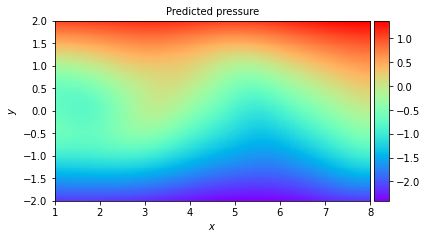

In [25]:
ax = plt.subplot(111)

h = ax.imshow(P_pred, interpolation='nearest', cmap='rainbow', 
                extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()], 
                origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)
